In [1]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

import pytz

# latitude, longitude, name, altitude, timezone
coordinates = [
    (55.786327, 12.524295, 'DTU', 700, 'America/Danmarkshavn'),
    (55.959534, 11.764390, 'Midtpunkt', 1500, 'America/Danmarkshavn'),
    (55.672759, 12.564814, 'København', 10, 'America/Danmarkshavn'),
    (55.622045, 12.078899, 'Roskilde', 34, 'America/Danmarkshavn'),
]

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

In [2]:
# Koden nedenunder filtrerer alle tidszoner ud af pytz' biblotek der inkluderer ordet "Danmark"
list(filter(lambda x: 'Danmark' in x, pytz.all_timezones))

['America/Danmarkshavn']

# Method 1
This procedual approach has a lower-level of abstraction.

Text(0, 0.5, 'Yearly energy yield (W hr)')

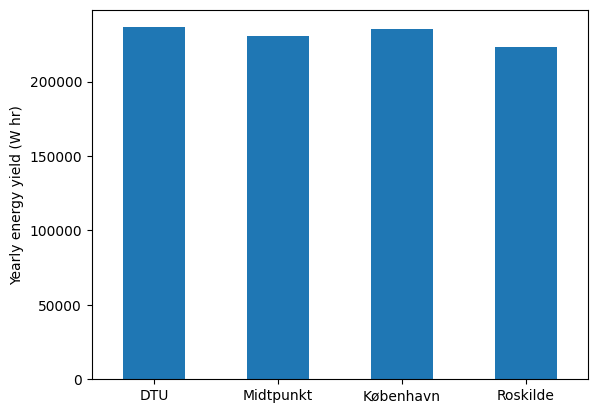

In [3]:
# Initialize system parameters including module, inverter, and surface azimuth
system = {'module': module, 'inverter': inverter, 'surface_azimuth': 180}

# Initialize dictionary to store annual energy yield for each location
energies = {}

# Iterate through locations and corresponding weather data
for location, weather in zip(coordinates, tmys):
    # Extract location information
    latitude, longitude, name, altitude, timezone = location
    
    # Set surface tilt based on latitude
    system['surface_tilt'] = latitude
    
    # Calculate solar position
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )

    # Calculate parameters for irradiance calculations
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )

    # Calculate total irradiance on the module
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )

    # Calculate effective irradiance
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )

    # Calculate cell temperature
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )

    # Calculate DC power output of the PV system
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    
    # Calculate AC power output of the PV system
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    
    # Calculate annual energy yield and store in the energies dictionary
    annual_energy = ac.sum()
    energies[name] = annual_energy

# Convert energies dictionary to pandas Series
energies = pd.Series(energies)

# Plot the yearly energy yield as a bar chart
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')

# Method 2
This approach uses higher-level abstractions provided by the pvlib library, such as PVSystem, Array, FixedMount, and ModelChain.

Text(0, 0.5, 'Yearly energy yield (W hr)')

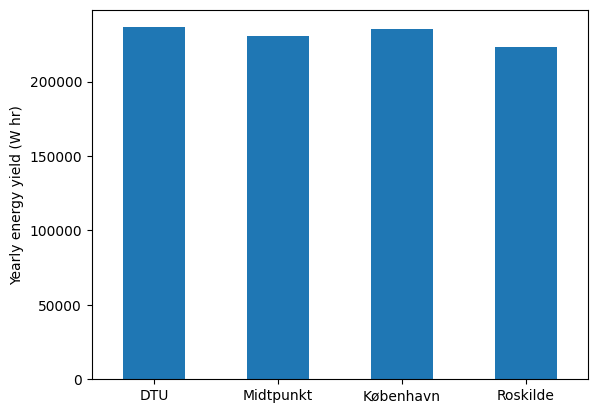

In [4]:
# Import necessary modules from pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# Initialize dictionary to store annual energy yield for each location
energies = {}

# Iterate through locations and corresponding weather data
for location, weather in zip(coordinates, tmys):
    # Extract location information
    latitude, longitude, name, altitude, timezone = location
    
    # Create Location object with latitude, longitude, name, altitude, and timezone
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )

    # Define mount configuration with fixed surface tilt and azimuth
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    
    # Create Array object with the mount configuration, module parameters, and temperature model parameters
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
    )

    # Create PVSystem object with the array and inverter parameters
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    
    # Create ModelChain object with the PVSystem and Location
    mc = ModelChain(system, location)
    
    # Run the model using weather data
    mc.run_model(weather)
    
    # Calculate annual energy yield and store in the energies dictionary
    annual_energy = mc.results.ac.sum()
    energies[name] = annual_energy

# Convert energies dictionary to pandas Series
energies = pd.Series(energies)

# Plot the yearly energy yield as a bar chart
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')